5/12/15 HW 3 Q.5 Building elements of Shazam
Localized Hashing

In [2]:
import json
import base64
from io import BytesIO
import numpy as np
from pydub import AudioSegment
import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter
from matplotlib import pyplot as plt
import hashlib
from collections import defaultdict
from collections import Counter

songs = sc.textFile("s3n://stat-37601/new-songs.mp3.base64.json",minPartitions = 100).map(json.loads)

5.a Compute the number of peaks for each song, and print out the average. Then, plot the
number of fingerprints per song in a bar chart.

In [4]:
# get the data piece of a song
def get_audio(song):
    return((song['song_id'],song['data']))
audio = songs.map(get_audio)
song_piece = audio.first()

# convert a song into samples in [-1, 1]
def audio_segment_to_samples(song):
    audio = AudioSegment.from_mp3(BytesIO(base64.b64decode(song)))
    wave = audio.export('_', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

# convert samples into a spectrogram and return peaks
def find_peaks(samples):
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
    # Don’t rescale by 1/f!
    maxes = (maximum_filter(ft_graph, size=20) == ft_graph) & \
    (ft_graph > -150)
    # Compute relative maxima 20 units away from others, where
    # intensity is greater than -150 dB.
    freqs, times = np.where(maxes)
    return (freqs, times)

In [5]:
samples = audio.mapValues(audio_segment_to_samples)
peaks = samples.mapValues(find_peaks)

In [6]:
def audio_segment_in_ipython(song):    
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px">
      <source controls
        src="data:audio/mp3;base64,{}" type="audio/mp3" />
    </audio>""".format(song)))

audio_segment_in_ipython(song_piece[1])

In [7]:
n_p = peaks.mapValues(lambda x: len(x[1])).collect()

We were given snippets of songs, group them by song id to get peaks per song. **Below you can see the number of peaks for the first 10 songs. **

In [8]:
d = defaultdict(list)
for k, v in n_p:
    d[k].append(v)

number_peaks = [(k,sum(v)) for k,v in d.items()]
print(number_peaks[:10],)

([(0, 10950), (1, 373999), (2, 34645), (3, 425219), (4, 38269), (5, 25025), (6, 34905), (7, 42252), (8, 55010), (9, 17608)],)


In [9]:
number_peaks = dict(number_peaks)
np.mean(number_peaks.values())

56485.933333333334

There are **43134** peaks on average. (This number changes a little each time you run it)
Histogram of number of peaks for our 90 songs shown below

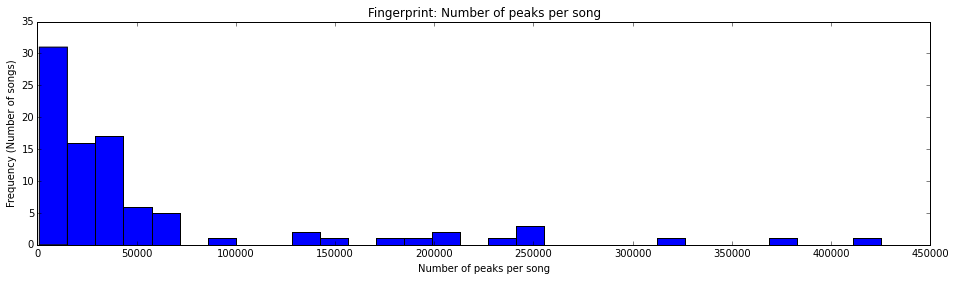

In [10]:
%matplotlib inline
plt.figure(figsize=(16, 4))
plt.hist(number_peaks.values(), bins=30)
plt.title("Fingerprint: Number of peaks per song")
plt.xlabel("Number of peaks per song")
plt.ylabel("Frequency (Number of songs)")
plt.show()

b.
Hashing:
As a convenient side effect of how this code operates, the resulting list of peaks will
be sorted by time. Use this to your advantage, and iterate through the list of peaks,
pairing those peaks less than 200 frames apart. For each pair (time1, freq1) and
(time2, freq2) , generate a hashed relative peak value, as with the following:
Use this function and the peaks given by find peaks to compute an RDD containing
tuples of the form (hashed paired peak, index) , where index is the unique
song ID for each song. Note that the above function takes the full 40 digits of the SHA-
1 hash (in hexadecimals). You can save storage and memory by taking less than the 40
digits at the cost of collision and misclassification.

In [11]:
def make_peaktuples(peaks):
    return(zip(peaks[1],peaks[0]))

peak_tuples = peaks.mapValues(make_peaktuples)

In [12]:
# returns only peaks that are <200 frames apart
def compare_peaks(peak_tuples, peaks_200=[]):
    for p1,p2 in zip(peak_tuples, peak_tuples[1:]):
        if (p2[1]-p1[1]<200):
            peaks_200.append((p1[0],p1[1],p2[0],p2[1]))
    return (peaks_200)

paired_peaks = peak_tuples.mapValues(compare_peaks)

In [13]:
#generate a hashed relative peak value for all songs
def hash_two_close_peaks(time1, freq1, time2, freq2,reduction=20):
    return hashlib.sha1("{}:{}:{}"
                        .format(time2 - time1, freq2, freq1)).hexdigest()[:(40-reduction)]

def get_hashes(song):
    x = (hash_two_close_peaks(p[0],p[1],p[2],p[3]) for p in song)
    return list(x)

Below we have the hashes for each paired peak that is less than 200 units apart

In [14]:
song_hashes = paired_peaks.mapValues(get_hashes)
song_hashes.first()[1][:3] # showing a few of the hashes for song 0

['fa274d3ce33e5b4e381c', '38c95fc5d9907aa1fae3', 'cb007ddf4f6c88e814f0']

Below you see the number of hashes per chunk

In [15]:
hash_counts_bychunk = song_hashes.mapValues(lambda x: len(x)) 
print(hash_counts_bychunk.take(10)),

[(0, 324), (0, 615), (0, 901), (0, 1194), (0, 1493), (0, 1772), (0, 2035), (0, 2300), (0, 2553), (0, 2816)]


In [16]:
# Group the chunks by song to count the number of hashes per song
hash_counts_bysong = hash_counts_bychunk.reduceByKey(lambda a, b: a + b)

**Below you see the number of hashes per song** The reduce operation take long because of the number of hashes ~100M

In [17]:
print(hash_counts_bysong.take(5)),

[(0, 219952), (1, 2280564), (2, 1024940), (3, 698116), (4, 857656)]


In [18]:
number_hashes = hash_counts_bysong.collect()

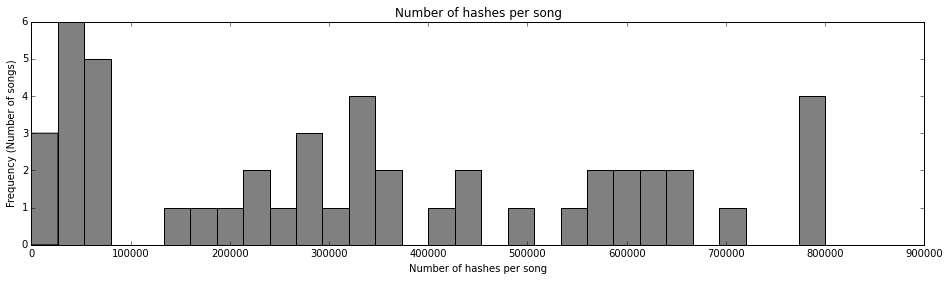

In [19]:
%matplotlib inline
plt.figure(figsize=(16, 4))
plt.hist(dict(number_hashes).values(), bins=30, range=[0, 800000], facecolor='gray', )
plt.title("Number of hashes per song")
plt.xlabel("Number of hashes per song")
plt.ylabel("Frequency (Number of songs)")
plt.show()

**Below you see the hash, song_id tuples.** Our fingerprints for each song!

In [20]:
def make_hash_song_tuple(song_hashes, hash_song=[]):
    for song_hash in song_hashes[1]:
            hash_song.append((song_hash,song_hashes[0]))
    return (hash_song)

hashes_song = song_hashes.map(make_hash_song_tuple)
print(hashes_song.first()[:3])

[('fa274d3ce33e5b4e381c', 0), ('38c95fc5d9907aa1fae3', 0), ('cb007ddf4f6c88e814f0', 0)]


In [21]:
print(len(hashes_song.first()))
print(len(dict(hashes_song.first())))

324
248


The above 2 lines show that within the chunks there are duplicate hashes (collisions?)   
We need to get rid of these to make our data tractable. This also indicates that the histogram aboe is an overestimate.

In [22]:
hashes_song_deduped = hashes_song.map(lambda x: dict(x))

I started to run in to all sorts of memory issues here, I have reduced the hashes to 20 characters.   
Running collect() or groupByKey() or any other method of getting (hash_key_pair, [index]) was not working

In [ ]:
hashes_song_list = hashes_song_deduped.collect()

In [ ]:
# I have a list of dictionaries
big_list = []
for hashes in hashes_song_list:
    big_list.append(hashes.items())

In [ ]:
# Now I have a list of lists, fix that
big_list2 = [item for sublist in big_list for item in sublist]

In [40]:
big_list2[:3]

[('2741309d5b01825b52bb', 0),
 ('09b0de448232941f2e6b', 0),
 ('8299e3243ce2145a44e8', 0)]

In [44]:
print(len(big_list2))
print(len(dict(big_list2)))

29538358
334923


The above numbers indicate the number of collisions

In [ ]:
group_indexes = defaultdict(list)
for k, v in big_list2:
    group_indexes[k].append(v)

In [ ]:
group_indexes.items()

In [ ]:
from sets import Set
group_unique_indexes = defaultdict(list)
for k,v in group_indexes.items(): 
    matches = Set(v)
    group_unique_indexes[k].append(list(matches))

Finally we have   
    (hashed paired peak, [index])    

In [67]:
group_unique_indexes.items()[:4]

[('d3f46899810b8026944a', [[70, 71]]),
 ('accbe76a00282efe4a2f', [[51, 18, 19, 20, 50]]),
 ('735fb90215d6c9263f58', [[31]]),
 ('fa3313e689537f6bdc19', [[58, 59]])]

In [ ]:
#generate a list of pairs of songs sharing it the hashed peaks
import itertools
group_unique_pairs = defaultdict(list)
for k,v in group_unique_indexes.items(): 
    group_unique_pairs[k].append(list(itertools.combinations(v[0],2)))

Here I've grouped the indexes into pairs

In [87]:
group_unique_pairs.items()[:7]

[('d3f46899810b8026944a', [[(70, 71)]]),
 ('735fb90215d6c9263f58', [[]]),
 ('fa3313e689537f6bdc19', [[(58, 59)]]),
 ('4550c931f4ab6ddc5ae9', [[(30, 31)]]),
 ('d0c819d1ab4ed9345e15', [[(74, 83), (74, 84), (83, 84)]]),
 ('dc1c13e70bd82458203a', [[]]),
 ('7252f898d0618abd494e', [[(59, 52)]])]